In [3]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [4]:
def undistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)


def plot_comparison(img1, img2):
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    plt.subplot(1,2,1)
    plt.imshow(img1)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(img2)
    plt.axis('off')

Camera calibrated using 20 images


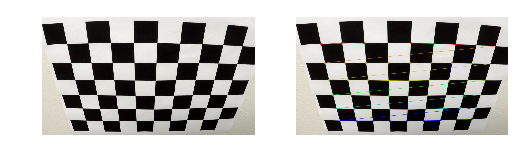

In [5]:
images = []

img, gray, img_corners, img_original = None, None, None, None

objpoints, imgpoints = [], []

image_files = glob.glob('camera_cal/calibration*.jpg')

for fname in image_files:

    nx, ny = 9, 6

    if 'calibration1.jpg' in fname:
        nx, ny = 9, 5
    if 'calibration4.jpg' in fname:
        nx, ny = 6, 5
    if 'calibration5.jpg' in fname:
        nx, ny = 7, 6

    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    # Save example image and corresponding identified corners
    if 'calibration2.jpg' in fname:
        img_original = img.copy()
        img_corners = img.copy()
        img_corners = cv2.drawChessboardCorners(img_corners, (nx, ny), corners, ret)
        cv2.imwrite('output_images/chessboard_original.jpg', img_original)
        cv2.imwrite('output_images/chessboard_corners.jpg', img_corners)

    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        images.append(img)
    else:
        print('Did not find corners', fname, (nx, ny))

plot_comparison(img_original, img_corners)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print('Camera calibrated using {0} images'.format(np.array(images).shape[0]))

True

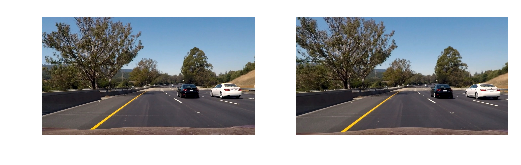

In [6]:
test_dir = 'test_images/'
cal_dir = 'camera_cal/'
out_dir = 'output_images/'

image_files = glob.glob(test_dir + '*.jpg')

for fname in image_files:
    img = cv2.imread(fname)
    undist = undistort(img, mtx, dist)
    
    fname = fname.replace(test_dir, out_dir)
    cv2.imwrite(fname, undist)
    
    plot_comparison(img, undist)
    

cal_img_orig = cv2.imread(cal_dir + 'calibration2.jpg')
cal_img_undist = undistort(img, mtx, dist)
cv2.imwrite(out_dir + 'chessboard_undistort.jpg', cal_img_undist)


True

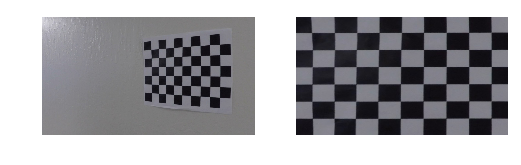

In [7]:
# Camera calibration sample image and corresponding parameters
cal_file = 'calibration12'
nx, ny = 9, 6
offset = 100 
x, y = gray.shape[::-1]

# Read image file, undistort, covert to grayscale and find chessboard corners
cal_img_orig = cv2.imread(cal_dir + cal_file + '.jpg')
cal_img_undist = undistort(cal_img_orig, mtx, dist)
gray = cv2.cvtColor(cal_img_undist, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

# Identify outer corners. Top-left, top-right, bottom-left, bottom-right.
src = np.float32([corners[0][0], corners[nx-1][0], corners[nx*(ny-1)][0], corners[nx*ny-1][0]])

# Create rectangle with corners positioned with a distance [offset, offset] from image frame corners
dst = np.float32([[offset, offset],[x-offset, offset],[offset, y-offset],[x-offset, y-offset]])

# Get perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)

# Calculate top-down image using perspective transform matrix
warped = cv2.warpPerspective(cal_img_undist, M, (x, y), flags=cv2.INTER_LINEAR)

# Plot comparison
plot_comparison(cal_img_orig, warped)

# Save example images to disk
cv2.imwrite(out_dir + cal_file + '_original.jpg', cal_img_orig)
cv2.imwrite(out_dir + cal_file + '_perspective_transform.jpg', warped)

In [25]:
def get_undistorted_image(fname, mtx, dist, gray_scale=False):
    img_orig = cv2.imread(fname)
    img_undist = undistort(img_orig, mtx, dist)
    color_profile = cv2.COLOR_BGR2GRAY if gray_scale else cv2.COLOR_BGR2RGB
    return cv2.cvtColor(img_undist, color_profile)

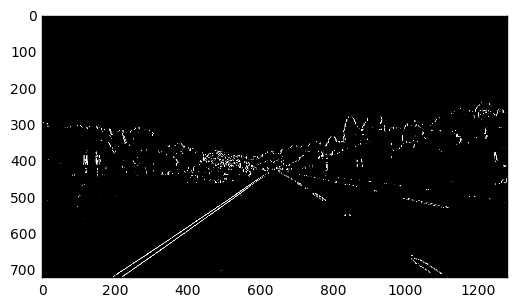

In [30]:
fname = out_dir + 'straight_lines1.jpg'
gray = get_undistorted_image(fname, mtx, dist, gray_scale=True)
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
abs_sobelx = np.absolute(sobelx)
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
thresh_min = 40
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
plt.imshow(sxbinary, cmap='gray')